# Проект: Обучение с учителем

Мы - небольшой отдел цифровых технологий. Наша компания, интернет-магазин «В один клик» хочет принимать решения только на основе анализа данных и бизнес-моделирования.

В частности, компания хочет разработать специализированные предложения для своих покупателей, чтобы удерживать активность постоянных клиентов. Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Поэтому ставку решили сделать на удержание уже лояльных покупателей.

Итак, нашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.


Руководитель отдела уже сформировал подход к решению задачи - ***нужно промаркировать уровень финансовой активности постоянных покупателей***

В компании принято выделять два уровня активности:
* «снизилась», если клиент стал покупать меньше товаров
* «прежний уровень»

Нужно собрать данные по клиентам по следующим группам:

* Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
* Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
* Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
* Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.

Представим группы признаков (вместе с целевым) в виде диаграммы — такую визуализацию ещё называют диаграммой Исикавы.

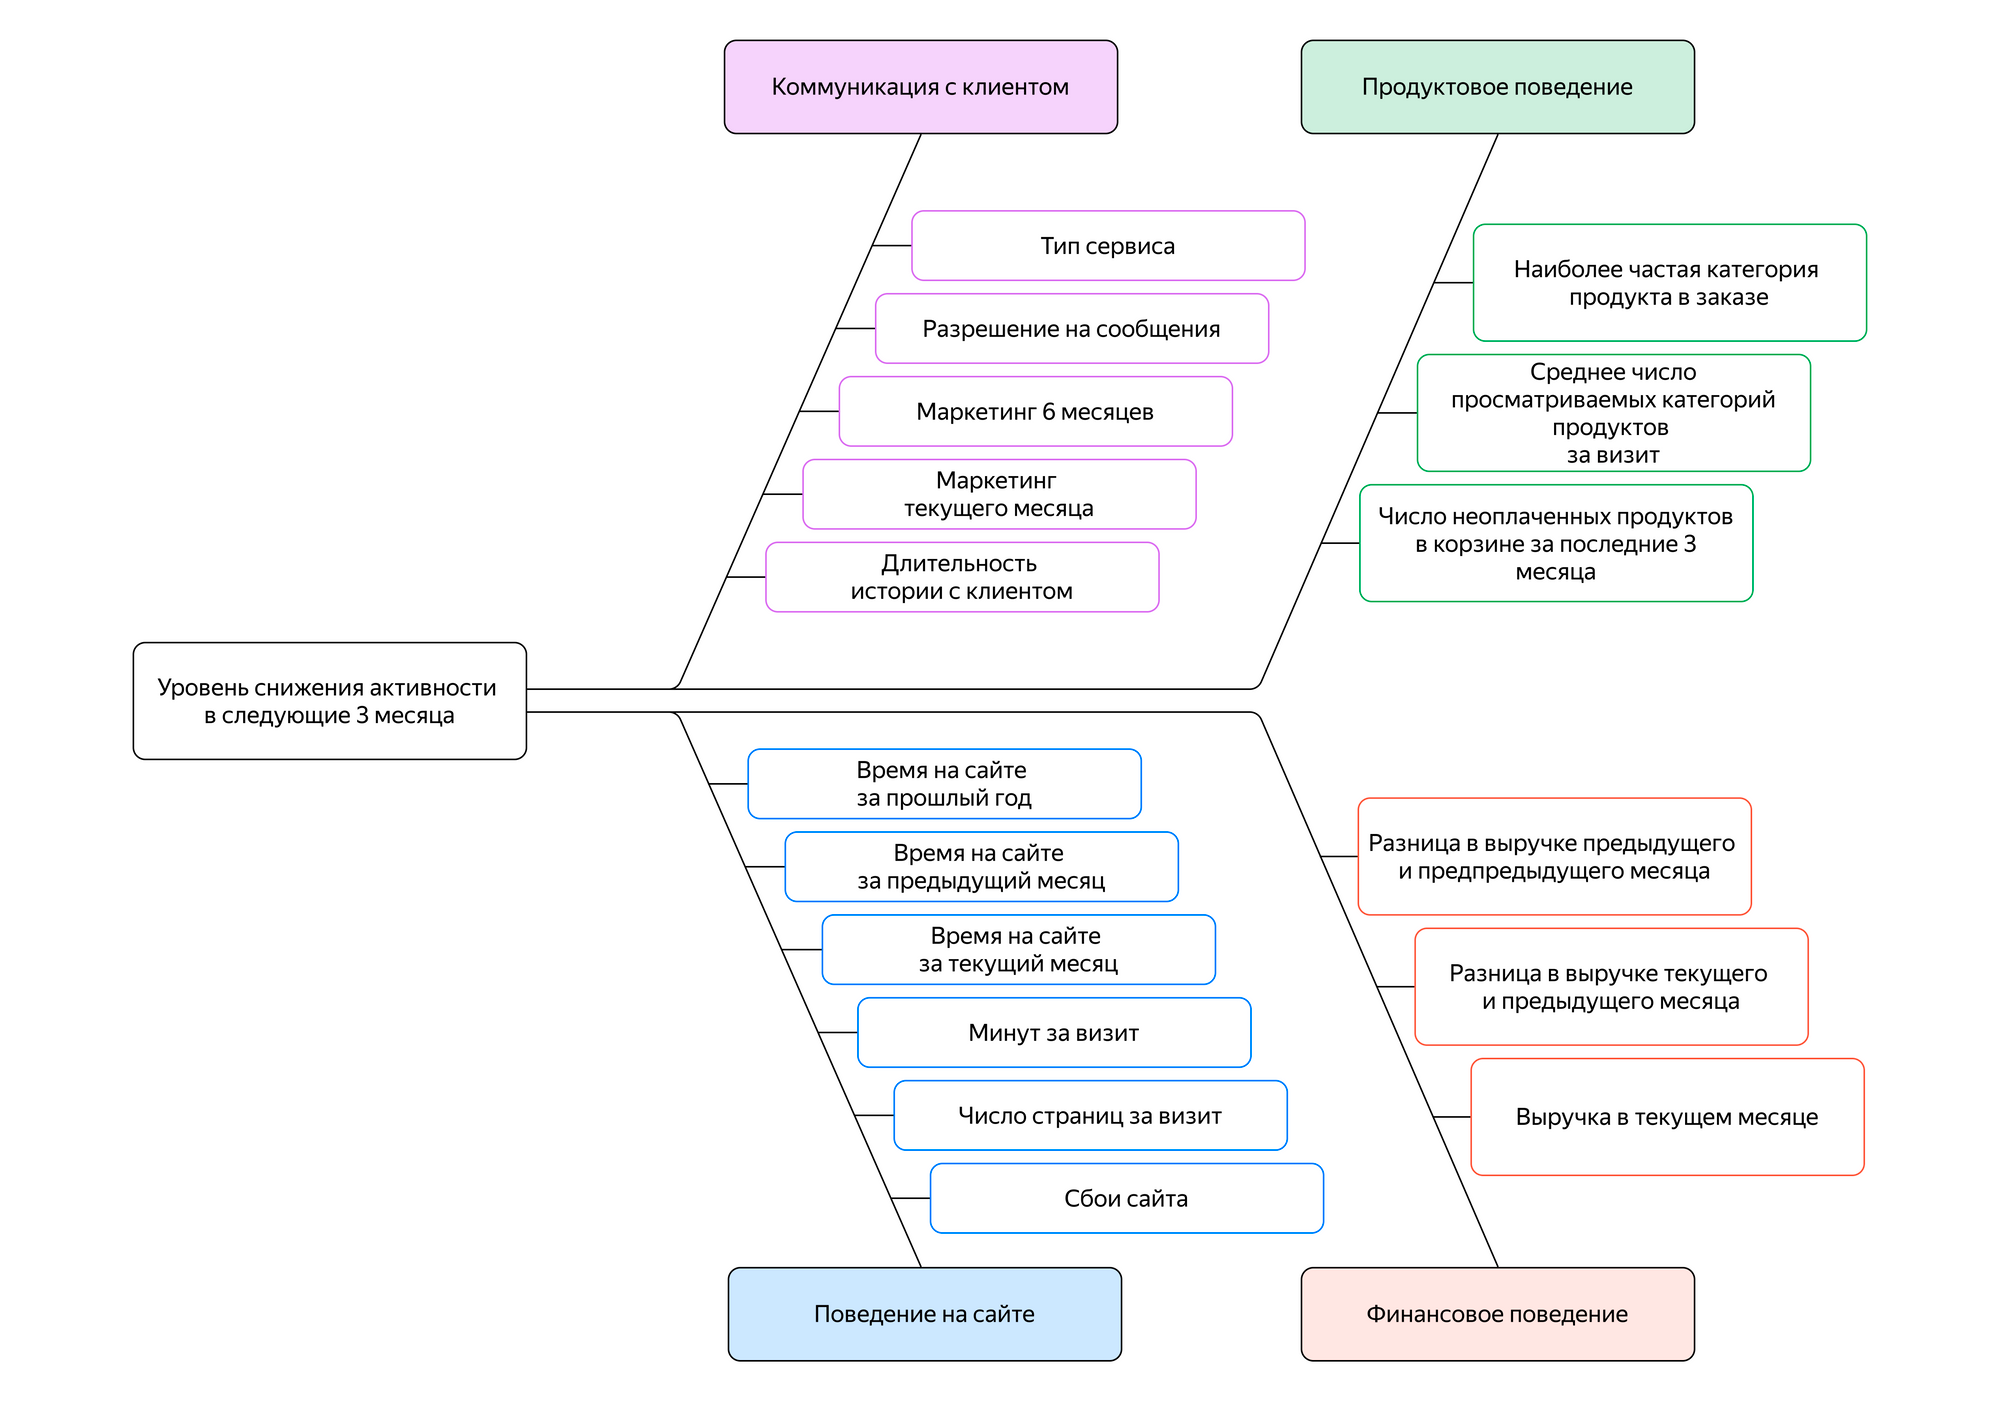



Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

---

### Описание данных

Данные для работы находятся в нескольких таблицах. Для начала работы импортируем все нужные библиотеки для дальнейшей обработки, анализа и построения моделей.

In [1]:
!pip install phik -q
!pip install shap -q

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import sklearn as sklearn
import time
import phik
import shap

In [3]:
from matplotlib.ticker import FuncFormatter
from phik import phik_matrix
from phik.report import plot_correlation_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score

In [4]:
try:
    market = pd.read_csv('market_file.csv', decimal=',')
    market_money = pd.read_csv('market_money.csv', decimal=',')
    market_time = pd.read_csv('market_time.csv', decimal=',')
    money = pd.read_csv('money.csv', sep=';', decimal=',')
    #ferma_dad = pd.read_csv('ferma_dad.csv', decimal=',')
except:
    market = pd.read_csv('/datasets/market_file.csv', decimal=',')
    market_money = pd.read_csv('/datasets/market_money.csv', decimal=',')
    market_time = pd.read_csv('/datasets/market_time.csv', decimal=',')
    money = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')
    #ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';', decimal=',')

FileNotFoundError: [Errno 2] No such file or directory: '/datasets/market_file.csv'

In [5]:
def data_head_desc_info(data):
    try:
        display('Первые 3 строки:')
        display(data.head(3))
        display('Описание данных:')
        display(data.describe())
        display('Общая информацию о датафрейме')
        display(data.info())
        display('Количество пропусков')
        display(data.isna().sum())
    except:
        return 'Проверьте параметры'

#### market_file

Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.



```
  `id` — номер покупателя в корпоративной базе данных.
  `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
  `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
  `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
  `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
  `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
  `Длительность`— значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
  `Акционные_покупки `— среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
  `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
  `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
  `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
  `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
  `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
```



In [6]:
data_head_desc_info(market)

NameError: name 'market' is not defined

Данные хорошо именованы и разделены, содержат 1300 записей без пропущенных значений. Все столбцы полностью заполнены.

Типы данных:

* Числовые данные: `id`, `Маркет_актив_6_мес`, `Маркет_актив_тек_мес`, `Длительность`, `Акционные_покупки`, `Средний_просмотр_категорий_за_визит`, `Неоплаченные_продукты_штук_квартал`, `Ошибка_сервиса`, `Страниц_за_визит`.

* Категориальные данные: `Покупательская_активность`, `Тип_сервиса`, `Разрешить_сообщать`.

Столбцы, связанные с активностью в магазине(`Маркет_актив_6_мес` и `Маркет_актив_тек_мес`), показывают среднее значение около 4, что может указывать на умеренную активность пользователей.

`Длительность` имеет среднее значение около 602 с широким разбросом значений (от 110 до 1079), что может свидетельствовать о значительных различиях во времени использования сервиса среди пользователей.

`Акционные_покупки` и `Неоплаченные_продукты_штук_квартал` имеют низкие средние значения, что может указывать на низкую склонность пользователей к покупке акционных товаров или наличие неоплаченных товаров.

#### market_money

Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.


```
id — номер покупателя в корпоративной базе данных.
Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
Выручка — сумма выручки за период.
```



In [7]:
data_head_desc_info(market_money)

'Первые 3 строки:'

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


'Описание данных:'

,id
count,3900.000000
mean,215997.500000
std,375.325686
min,215348.000000
25%,215672.750000
50%,215997.500000
75%,216322.250000
max,216647.000000


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3900 non-null   int64 
 1   Период   3900 non-null   object
 2   Выручка  3900 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.5+ KB


None

'Количество пропусков'

id         0
Период     0
Выручка    0
dtype: int64

Таблица содержит 3900 записей, без пропусков. Столбец Выручка требует трансформации типа.



#### market_time

Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.


```
id — номер покупателя в корпоративной базе данных.
Период — название периода, во время которого зафиксировано общее время.
минут — значение времени, проведённого на сайте, в минутах.
```



In [8]:
data_head_desc_info(market_time)

'Первые 3 строки:'

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10


'Описание данных:'

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

'Количество пропусков'

id        0
Период    0
минут     0
dtype: int64

Таблица содержит 2600 записей, без пропусков.

Покупатели проводят на сайте от 4 до 23 минут, со стандартным отклонением 4 минуты. Среднее время на сайте 13.4 минуты, медиана 13 минут - выбросов нет.

#### money

Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.



```
id — номер покупателя в корпоративной базе данных.
Прибыль — значение прибыли.
```


In [9]:
data_head_desc_info(money)

'Первые 3 строки:'

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13


'Описание данных:'

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


'Общая информацию о датафрейме'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

'Количество пропусков'

id         0
Прибыль    0
dtype: int64

Таблица содержит 1300 записей, пропусков нет.

Среднемесячное значение прибыли находится в диапазоне от 0.9 до 7.4 единиц (тысяч рублей?). Среднее значение 3.99, медиана 4.04 - выбросов нет.


#### Промежуточный вывод
Мы загрузили таблицы и сделали их предварительный обзор. Он показал:


1.  `market_file`

 * Тип данных столбцов не требует изменений.

 * Пропусков нет.

2. Таблица о потраченных деньгах `market_money`. о времени `market_time` и прибыли полеченной `money` с клиентов связаны с перовой таблицей через `id`.


##  Предобработка данных

Исправляем тип данных столбцов.

In [10]:
market['Маркет_актив_6_мес'] = market['Маркет_актив_6_мес'].astype(float)
market['Акционные_покупки'] = market['Акционные_покупки'].astype(float)

market_money['Выручка'] = market_money['Выручка'].astype(float)

Переименуем некоторые столбцы.

In [11]:
market.rename(columns={
    'Покупательская активность': 'Покупательская_активность',
    'Тип сервиса': 'Тип_сервиса',
    'Разрешить сообщать': 'Разрешить_сообщать'
}, inplace=True)
market_time.rename(columns={
    'минут': 'Минут'
}, inplace=True)

In [12]:
print(market.columns)
print(market_money.columns)
print(market_time.columns)
print(money.columns)

Index(['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')
Index(['id', 'Период', 'Выручка'], dtype='object')
Index(['id', 'Период', 'Минут'], dtype='object')
Index(['id', 'Прибыль'], dtype='object')


### 2.1 Пропуски



Обзор данных с помощью функции data_head_desc_info() показал, что пропусков нет.
Проверим данные на дубликаты.

### 2.2 Дубликаты

In [13]:
print('Дубликаты в таблице market', market.duplicated().sum())
print('Дубликаты в таблице market_money', market_money.duplicated().sum())
print('Дубликаты в таблице market_time', market_time.duplicated().sum())
print('Дубликаты в таблице money', money.duplicated().sum())

Дубликаты в таблице market 0
Дубликаты в таблице market_money 0
Дубликаты в таблице market_time 0
Дубликаты в таблице money 0


Проверим дупликаты по id.

In [14]:
print('Дубликаты id в market', market[market['id'].duplicated()].sum())

Дубликаты id в market id                                     0.0
Покупательская_активность              0.0
Тип_сервиса                            0.0
Разрешить_сообщать                     0.0
Маркет_актив_6_мес                     0.0
Маркет_актив_тек_мес                   0.0
Длительность                           0.0
Акционные_покупки                      0.0
Популярная_категория                   0.0
Средний_просмотр_категорий_за_визит    0.0
Неоплаченные_продукты_штук_квартал     0.0
Ошибка_сервиса                         0.0
Страниц_за_визит                       0.0
dtype: float64


Проверим неявные дубликаты. Посмотрим на уникальные значения категориальных столбцов.

In [15]:
print(market['Покупательская_активность'].unique())
print(market['Тип_сервиса'].unique())
print(market['Разрешить_сообщать'].unique())
print(market['Популярная_категория'].unique())

['Снизилась' 'Прежний уровень']
['премиум' 'стандартт' 'стандарт']
['да' 'нет']
['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


In [16]:
#исправляем ошибку в значении Тип сервиса, чтобы избавиться от дубликатов
market['Тип_сервиса'] = market['Тип_сервиса'].replace('стандартт', 'стандарт')
print(market['Тип_сервиса'].unique())

['премиум' 'стандарт']


In [17]:
print(market_money['Период'].unique())
print(market_time['Период'].unique())

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']
['текущий_месяц' 'предыдцщий_месяц']


Дубликатов нет. Поправим опечатку в значении.

In [18]:
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
print(market_time['Период'].unique())

['текущий_месяц' 'предыдущий_месяц']


### Промежуточный вывод

Столбцы были переименованы для удобства работы с кодом.

Пропусков в датафреймах не найдено. Явных дубликатов не найдено. Неявные дубликаты в категориальных столбцах удалены, таким образом повторялись значения в столбце Тип сервиса.

## Исследовательский анализ данных

Проведем исследовательский анализ данных из каждой таблицы. Затем отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.



### market_file

#### Категориальные признаки

Сначала рассмотрим категориальные признаки.

In [19]:
market_cat_cols = market.select_dtypes(exclude=['number']).columns
market_cat_cols

Index(['Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Популярная_категория'],
      dtype='object')

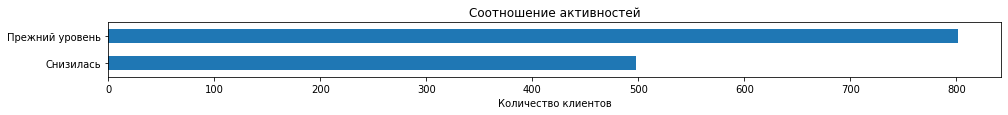

In [20]:
market['Покупательская_активность'].value_counts(ascending=True).plot.barh(figsize = (16, 1))
plt.title('Соотношение активностей')
plt.xlabel("Количество клиентов")
plt.show()

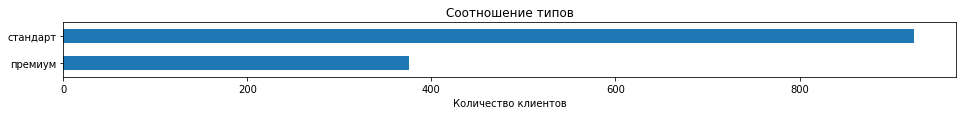

In [21]:
market['Тип_сервиса'].value_counts(ascending=True).plot.barh(figsize = (16, 1))
plt.title('Соотношение типов')
plt.xlabel("Количество клиентов")
plt.show()

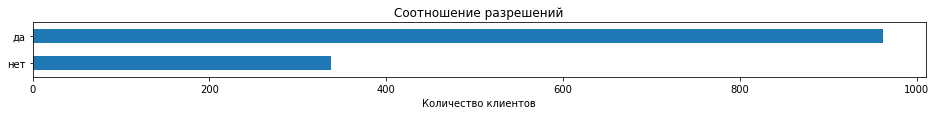

In [22]:
market['Разрешить_сообщать'].value_counts(ascending=True).plot.barh(figsize = (16, 1))
plt.title('Соотношение разрешений')
plt.xlabel("Количество клиентов")
plt.show()

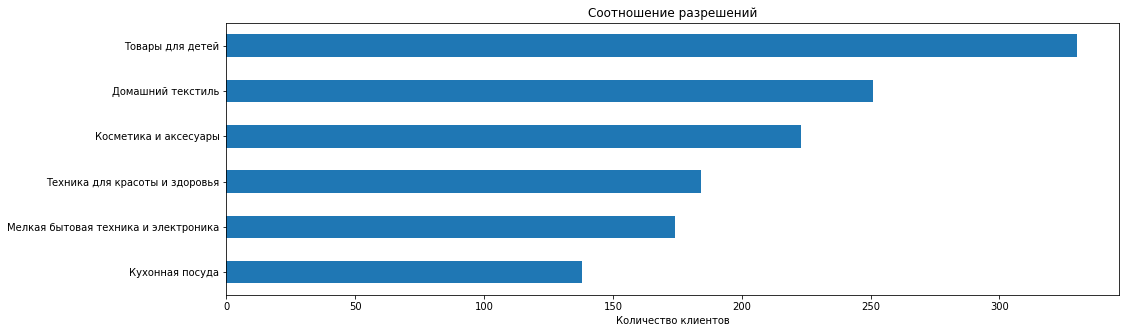

In [23]:
market['Популярная_категория'].value_counts(ascending=True).plot.barh(figsize = (16, 5))
plt.title('Соотношение разрешений')
plt.xlabel("Количество клиентов")
plt.show()

Покупательская активность снизила у ~500 человек. Примерно 800 клиентов сохраняют прежнюю активность.

Более 850 человек остаются с типом сервиса Стандарт. Тип Премиум выбирает около 350 человек.

Более 950 человек против 350 предпочитают получать дополнительные предложения о товаре.

Самая популярная категория товаров - Товары для детей.

#### Количественные признаки

In [24]:
market_num_cols = market.select_dtypes(include=['number']).columns
market_num_cols = market_num_cols.drop('id')
market_num_cols

Index(['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')

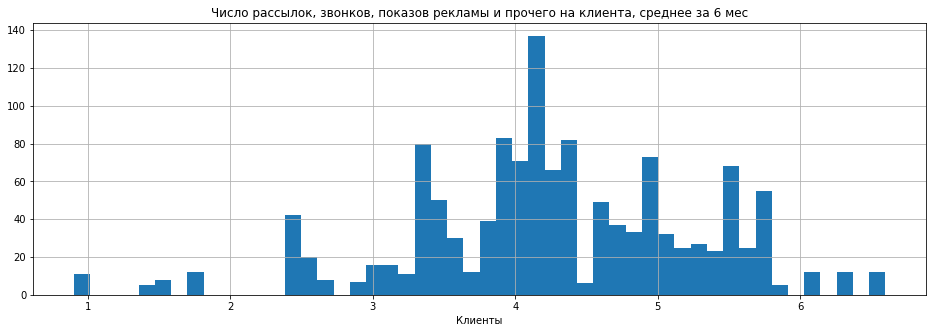

In [25]:
market['Маркет_актив_6_мес'].hist(figsize = (16, 5), bins=50)
plt.title('Число рассылок, звонков, показов рекламы и прочего на клиента, среднее за 6 мес')
plt.xlabel('Клиенты')
#plt.ylabel('')
plt.show()

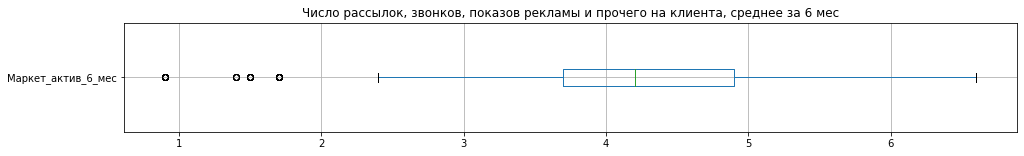

In [26]:
market.boxplot(column="Маркет_актив_6_мес",figsize = (16, 2), vert=False)
plt.title('Число рассылок, звонков, показов рекламы и прочего на клиента, среднее за 6 мес')
plt.show()

Среднее число активностей 4.011. Предполагаем, что число активностей зависит от алгоритма, которым владеет маркетинговый отдел. Это должно объяснять, почему число активностей на клиента не одинаковое для всех клиентов.

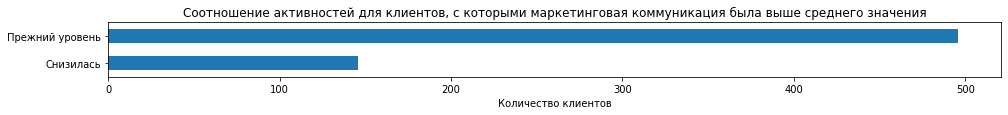

In [27]:
market[market['Маркет_актив_6_мес'] > market['Маркет_актив_6_мес'].mean()]['Покупательская_активность'].value_counts(ascending=True).plot.barh(figsize = (16, 1))
plt.title('Соотношение активностей для клиентов, с которыми маркетинговая коммуникация была выше среднего значения')
plt.xlabel("Количество клиентов")
plt.show()

Интересно посмотреть, влияет ли большое число маркетинговых активностей на количество покупок клиента. То есть получается ли у маркетинга подогревать покупки.

Выберем из датасета market только тех клиентов, у которых значение Снизилась в Покупательская активность и посмотрим графически, есть ли зависимость между количеством клиентов и числом маркетинговых коммуникаций (МК).

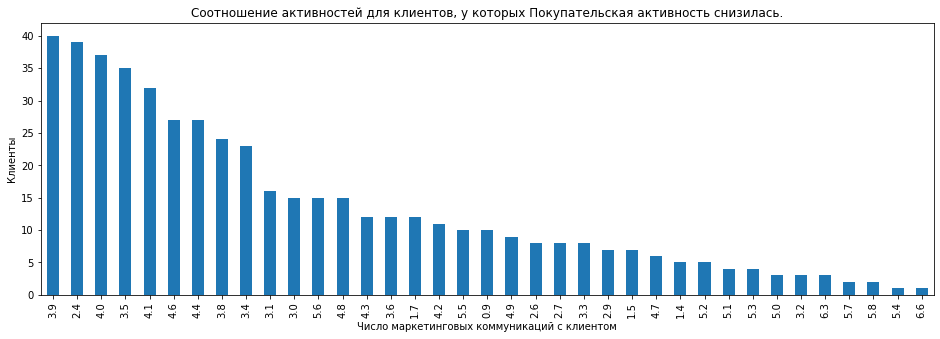

In [28]:
market[market['Покупательская_активность'] == 'Снизилась']['Маркет_актив_6_мес'].value_counts(ascending=False).plot.bar(figsize = (16, 5))
plt.title('Соотношение активностей для клиентов, у которых Покупательская активность снизилась.')
plt.xlabel("Число маркетинговых коммуникаций с клиентом")
plt.ylabel("Клиенты")
plt.show()

График убывает из за value_counts и построен не для всех значений числа МК. Однако, в первой трети этого распределения нет числа выше 5. А вот в конце графика, где число клиентов со снизившейся активностью не превышает 5, среднее значение МК всегда выше 5.

В разделе корреляционного анализа точнее увидим зависимость: есть ли корреляция между числом МК и Покупательской активностью.

Продолжим исследовать количественные признаки.

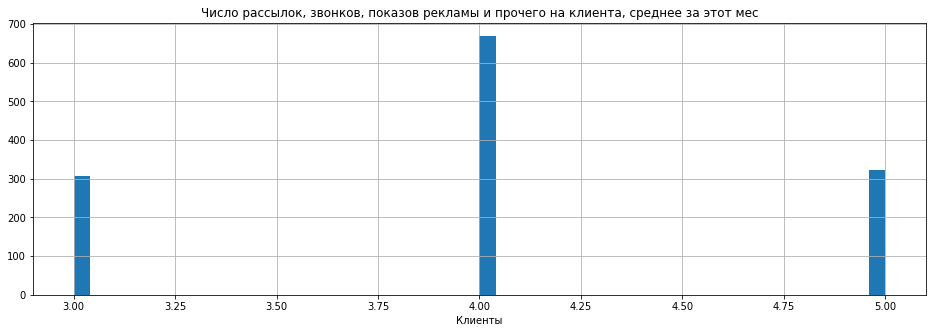

In [29]:
market['Маркет_актив_тек_мес'].hist(figsize = (16, 5), bins=50)
plt.title('Число рассылок, звонков, показов рекламы и прочего на клиента, среднее за этот мес')
plt.xlabel('Клиенты')
#plt.ylabel('')
plt.show()

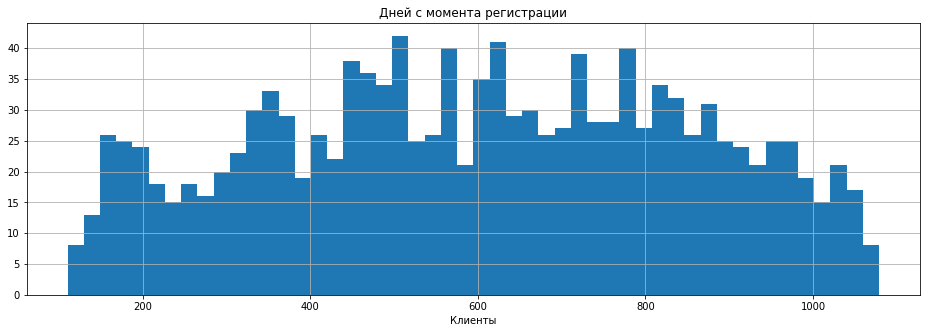

In [30]:
market['Длительность'].hist(figsize = (16, 5), bins=50)
plt.title('Дней с момента регистрации')
plt.xlabel('Клиенты')
#plt.ylabel('')
plt.show()

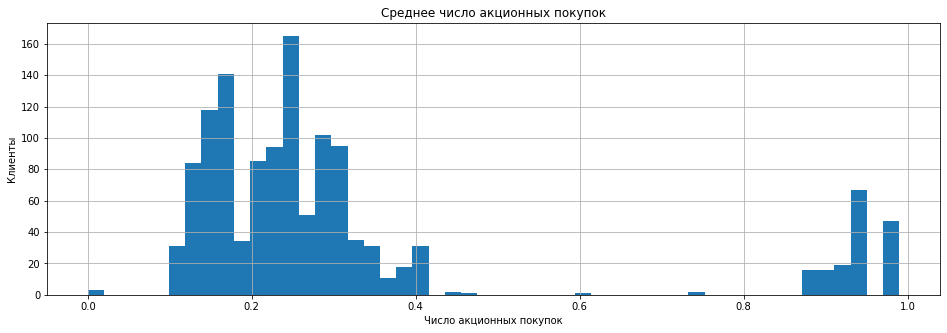

In [31]:
market['Акционные_покупки'].hist(figsize = (16, 5), bins=50)
plt.title('Среднее число акционных покупок')
plt.xlabel('Число акционных покупок')
plt.ylabel('Клиенты')
plt.show()

У распределения 2 пика: близ 0.25 и 0.95.

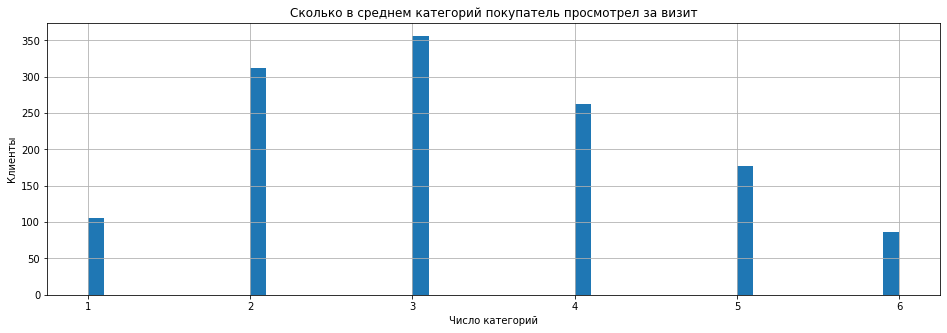

In [32]:
market['Средний_просмотр_категорий_за_визит'].hist(figsize = (16, 5), bins=50)
plt.title('Сколько в среднем категорий покупатель просмотрел за визит')
plt.xlabel('Число категорий')
plt.ylabel('Клиенты')
plt.show()

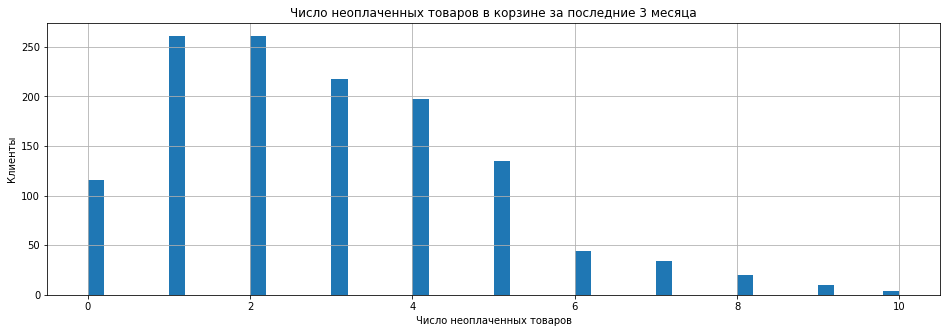

In [33]:
market['Неоплаченные_продукты_штук_квартал'].hist(figsize = (16, 5), bins=50)
plt.title('Число неоплаченных товаров в корзине за последние 3 месяца')
plt.xlabel('Число неоплаченных товаров')
plt.ylabel('Клиенты')
plt.show()

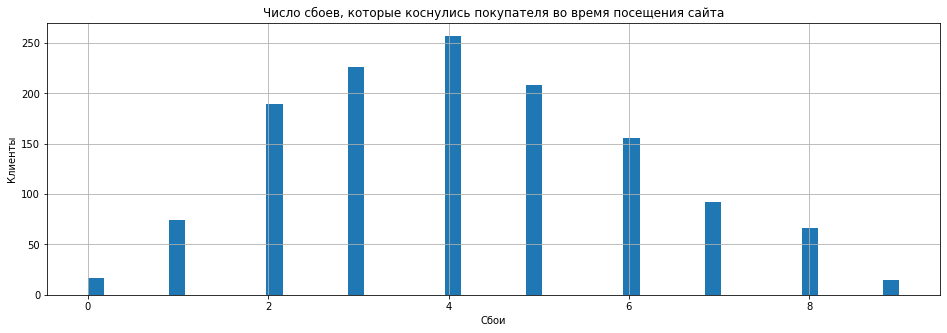

In [34]:
market['Ошибка_сервиса'].hist(figsize = (16, 5), bins=50)
plt.title('Число сбоев, которые коснулись покупателя во время посещения сайта')
plt.xlabel('Сбои')
plt.ylabel('Клиенты')
plt.show()

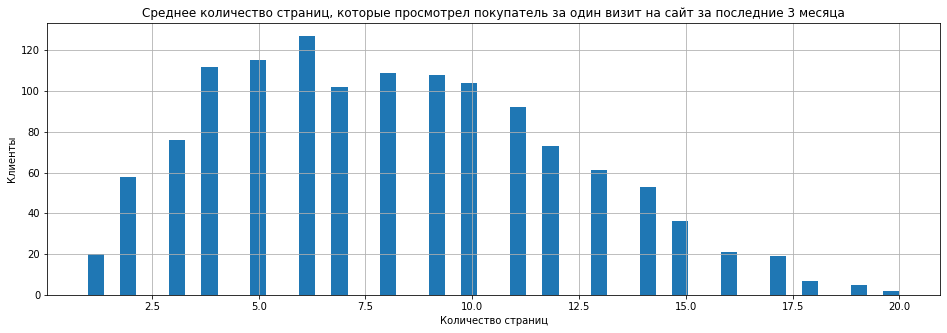

In [35]:
market['Страниц_за_визит'].hist(figsize = (16, 5), bins=50)
plt.title('Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца')
plt.xlabel('Количество страниц')
plt.ylabel('Клиенты')
plt.show()

### market_money

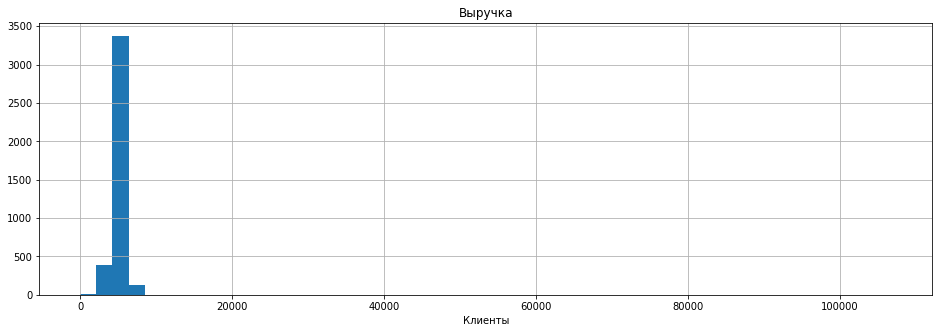

In [36]:
market_money['Выручка'].hist(figsize = (16, 5), bins=50)
plt.title('Выручка')
plt.xlabel('Клиенты')
plt.show()

Такая пустая диаграмма означает что присутствует выброс. Убедимся на боксплоте.

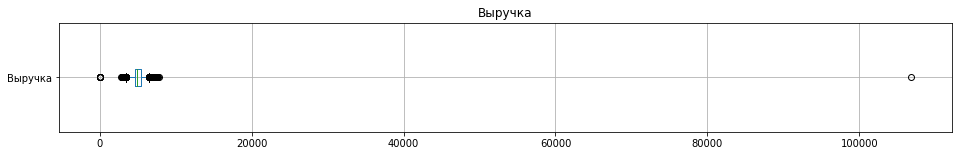

In [37]:
market_money.boxplot(column="Выручка",figsize = (16, 2), vert=False)
plt.title('Выручка')
plt.show()

Посмотрим выброс и его строку. Нам нужен его индекс.

In [38]:
market_money.sort_values(by='Выручка', ascending=False).head(3)

,id,Период,Выручка
98,215380,текущий_месяц,106862.2
435,215493,текущий_месяц,7799.4
262,215435,текущий_месяц,7605.3


Чтобы не удалять строку, заменим значение медианой. Оно явно было внесено с ошибкой.

In [39]:
market_money.loc[[98],'Выручка'] = market_money['Выручка'].median()
market_money.loc[[98],'Выручка']

98    4957.5
Name: Выручка, dtype: float64

Убедимся, что избавились от выброса. Снова посмотрим на диаграммы выручки за разные периоды.

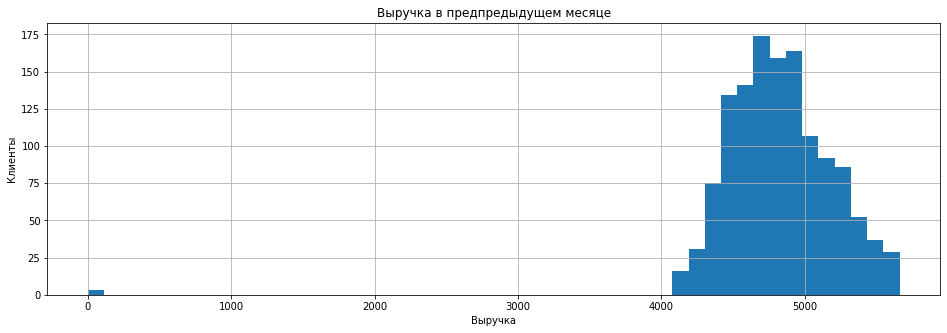

In [40]:
market_money[market_money['Период']=='препредыдущий_месяц']['Выручка'].hist(figsize = (16, 5), bins=50)
plt.title('Выручка в предпредыдущем месяце')
plt.ylabel('Клиенты')
plt.xlabel('Выручка')
plt.show()

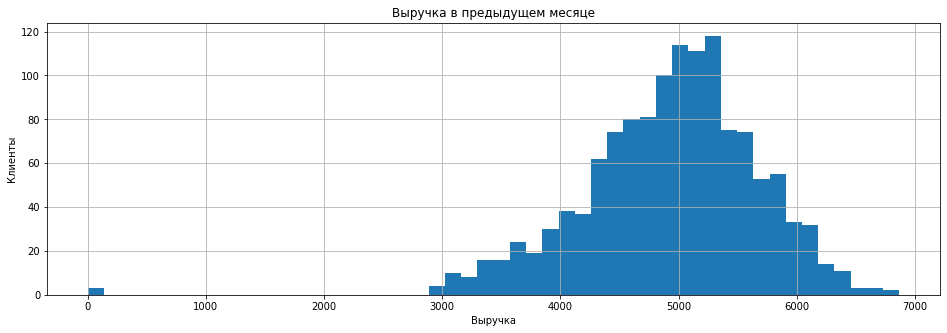

In [41]:
market_money[market_money['Период']=='предыдущий_месяц']['Выручка'].hist(figsize = (16, 5), bins=50)
plt.title('Выручка в предыдущем месяце')
plt.ylabel('Клиенты')
plt.xlabel('Выручка')
plt.show()

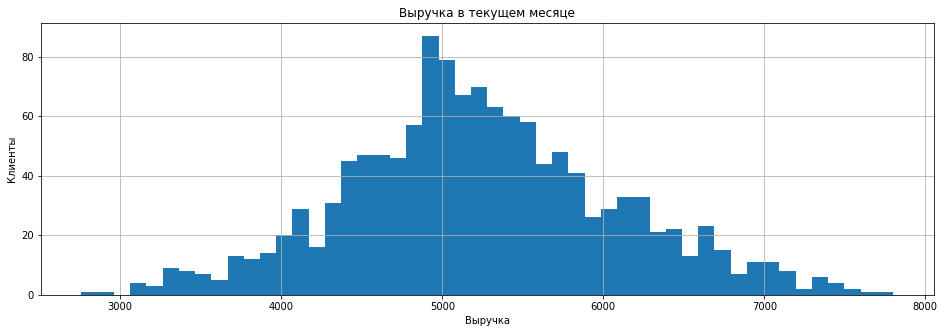

In [42]:
market_money[market_money['Период']=='текущий_месяц']['Выручка'].hist(figsize = (16, 5), bins=50)
plt.title('Выручка в текущем месяце')
plt.ylabel('Клиенты')
plt.xlabel('Выручка')
plt.show()

Увеличилась дисперсия для распределения выручки от наиболее далекого периода Препредыдущий месяц до Текущий месяц.

Также в Текущем месяце нет клиентов с Выручкой = 0. Максимальная выручка с клиента в Текущем месяце тоже увеличилась.

Есть гипотеза, что это может быть связано с увеличением активности отдела маркетинга. Мы проверим эту зависимость от времени после объединения таблиц.

### market_time

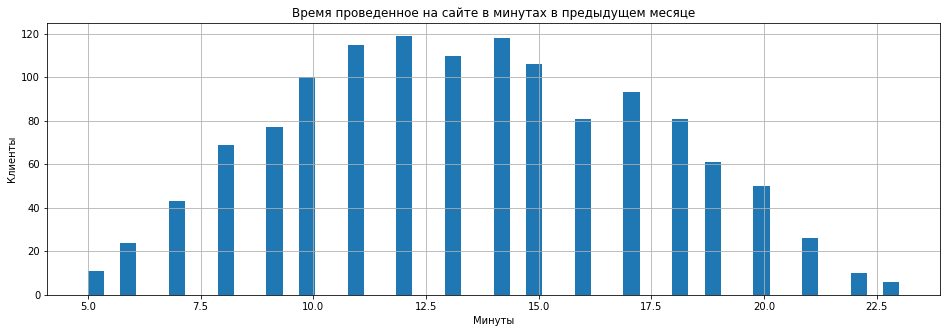

In [43]:
market_time[market_time['Период'] == 'предыдущий_месяц']['Минут'].hist(figsize = (16, 5), bins=50)
plt.title('Время проведенное на сайте в минутах в предыдущем месяце')
plt.xlabel('Минуты')
plt.ylabel('Клиенты')
plt.show()

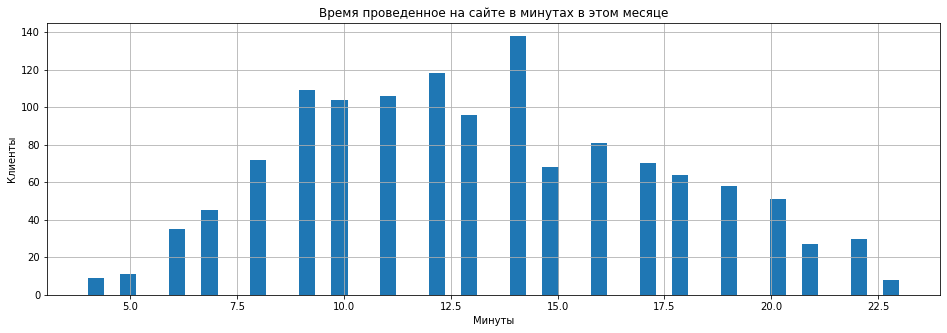

In [44]:
market_time[market_time['Период'] == 'текущий_месяц']['Минут'].hist(figsize = (16, 5), bins=50)
plt.title('Время проведенное на сайте в минутах в этом месяце')
plt.xlabel('Минуты')
plt.ylabel('Клиенты')
plt.show()

Увеличилось время пребывания на сайте в текущем месяце по сравнению с предыдущим.

### money

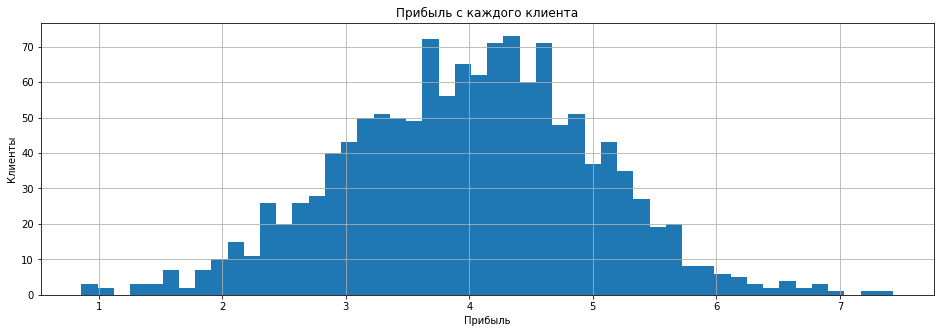

In [45]:
money['Прибыль'].hist(figsize = (16, 5), bins=50)
plt.title('Прибыль с каждого клиента')
plt.xlabel('Прибыль')
plt.ylabel('Клиенты')
plt.show()

К сожалению, нет признака о времени получения прибыли с клиента за разные периоды времени.

Распределение близко к нормальному, без выбросов.

### Вывод по Исследовательскому анализу

В рамках исследовательского анализа был проведен подробный анализ категориальных и количественных признаков клиентской базы интернет-магазина. Были раздельно рассмотрены все 4 предоставленных датасета market_file, market_money и market_time. Для файла money не было получено особых выводов кроме того, что распределение прибыли с клиентов близко к нормальному и не содержит выбросов.

Использовались методы визуализации данных, такие как гистограммы и барные графики, для анализа распределения различных признаков, включая покупательскую активность, типы услуг, возможности отправки сообщений, популярные категории товаров, а также показатели активности, такие как количество просмотров и покупок.

* Покупательская активность снизила у ~500 человек. Примерно 800 клиентов сохраняют прежнюю активность.

* Более 850 человек остаются с типом сервиса Стандарт. Тип Премиум выбирает около 350 человек.

* Более 950 человек против 350 предпочитают получать дополнительные предложения о товаре.

* Самая популярная категория товаров - Товары для детей.

* Среднее число маркетинговых активностей на клиента 4.011.
* Есть предположение, что низкое число маркетинговых активностей (ниже 5) влияет на сниженную покупательскую активность
* У распределения Акционных покупок 2 пика: близ 0.25 и 0.95. Скорее всег второй пик означает, что есть покупатели, совершающие только покупки по акции.
* В среднем покупатель просматривает 3 категории за визит, не оплачивает и оставляет в корзине 2 товара и получает 4 ошибки сервиса. Последнее значение достаточно больше, может влиять на снижение покупательской активности.

* Увеличилась дисперсия для распределения выручки от наиболее далекого периода Препредыдущий месяц до Текущий месяц. Также в Текущем месяце нет клиентов с Выручкой = 0. Максимальная выручка с клиента в Текущем месяце тоже увеличилась.

* Увеличилось время пребывания на сайте, что хорошо.


### Объединение таблиц



Объединим таблицы  `market_file.csv`, `market_money.csv`, `market_time.csv`.

Таблицу `money` в объединении использовать не будем. В ней нет данных о времени, в моделировании она не поможет.

Еще раз проверим названия столбцов:

In [46]:
print(market.columns)
print(market_money.columns)
print(market_time.columns)

Index(['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит'],
      dtype='object')
Index(['id', 'Период', 'Выручка'], dtype='object')
Index(['id', 'Период', 'Минут'], dtype='object')


In [47]:
market.head(3)

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5


In [48]:
market_money.head(3)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0


Используем сводные таблицы, развернем их так, чтобы в столбцах остались только периоды со значениями Выручки или Минут соответственно. Избавимся от записей, если хоть в одном столбце будет 0.

In [49]:
market_money_pivot = pd.pivot_table(market_money, index='id', columns='Период', values='Выручка')
market_money_pivot.columns = ['Выручка_пред_мес','Выручка_предпред_мес', 'Выручка_тек_мес']
market_money_pivot.head(20)

,Выручка_пред_мес,Выручка_предпред_мес,Выручка_тек_мес
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5
215354,5685.0,4503.0,5869.6
215355,3263.0,4749.0,3772.6
215356,4146.5,4433.0,4566.4


In [50]:
# Удаляем строки, где есть нулевые значения
columns_to_check = market_money_pivot.columns.difference(['id'])
market_money_pivot = market_money_pivot[~(market_money_pivot[columns_to_check] == 0).any(axis=1)]

In [51]:
market_time.head(3)

,id,Период,Минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10


In [52]:
market_time_pivot = pd.pivot_table(market_time, index='id', columns='Период', values='Минут')
market_time_pivot.columns = ['Минут_пред_мес', 'Минут_тек_мес']

# Удаляем строки, где есть нулевые значения
columns_to_check = market_time_pivot.columns.difference(['id'])
market_time_pivot = market_time_pivot[~(market_time_pivot[columns_to_check] == 0).any(axis=1)]
market_time_pivot.shape

(1300, 2)

Теперь можем объединить таблицы.

In [53]:
market_full = market.merge(
    market_money_pivot, on='id', how='inner'
    ).merge(
    market_time_pivot, on='id', how='inner'
    )

market_full.shape

(1297, 18)

In [54]:
display(market_full.head(10))
display(market_full.info())

,id,Покупательская_активность,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_пред_мес,Выручка_предпред_мес,Выручка_тек_мес,Минут_пред_мес,Минут_тек_мес
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10
5,215354,Снизилась,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,5869.6,11,12
6,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10
7,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,2,2,1,3,4146.5,4433.0,4566.4,6,7
8,215358,Снизилась,стандарт,да,4.7,4,450,0.13,Домашний текстиль,4,2,6,4,3488.0,4727.0,4209.5,14,10
9,215360,Снизилась,премиум,да,3.9,3,623,0.35,Кухонная посуда,3,1,4,7,5304.5,5555.0,5834.9,9,6


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   Покупательская_активность            1297 non-null   object 
 2   Тип_сервиса                          1297 non-null   object 
 3   Разрешить_сообщать                   1297 non-null   object 
 4   Маркет_актив_6_мес                   1297 non-null   float64
 5   Маркет_актив_тек_мес                 1297 non-null   int64  
 6   Длительность                         1297 non-null   int64  
 7   Акционные_покупки                    1297 non-null   float64
 8   Популярная_категория                 1297 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  Ошибка_сервиса                

None

Таблицы объединены, пропуски отсутствуют. Успешно!

## Корреляционный анализ

#### Общий

Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками. Сразу построим матрицу корреляции.

interval columns not set, guessing: ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'Выручка_пред_мес', 'Выручка_предпред_мес', 'Выручка_тек_мес', 'Минут_пред_мес', 'Минут_тек_мес']


<AxesSubplot:>

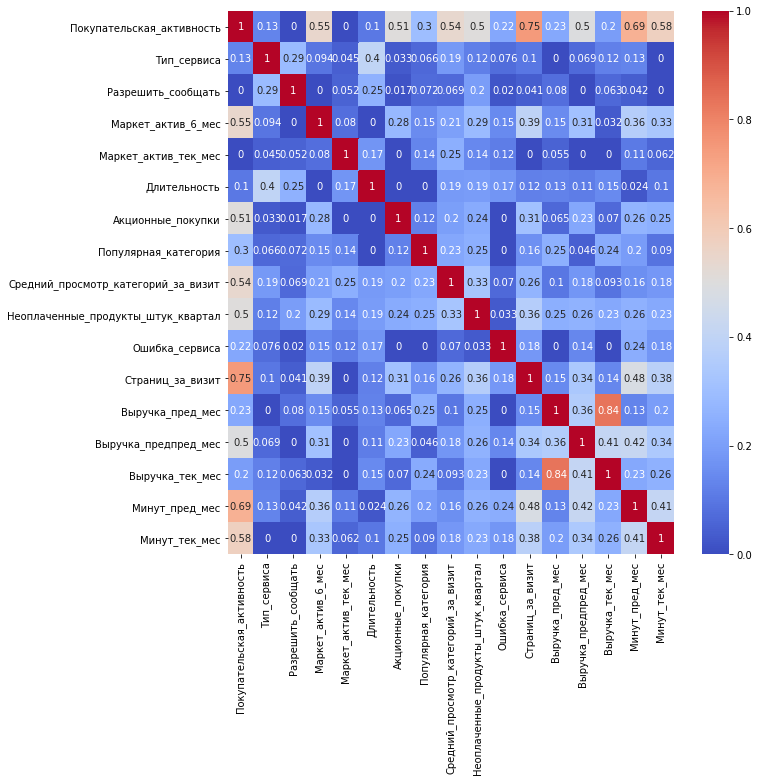

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(market_full.drop('id', axis=1).phik_matrix(),
            annot=True,
            cmap='coolwarm',
            ax=ax)

Посмотрим на корреляционную матрицу и выделим высокие и средние коэффициенты для целевого признака **Покупательская_активность** (Пирсона по умолчанию):

* **Покупательская активность и Страницы за визит (0.75)**: 
 
 Это указывает на сильную корреляцию. Скорее всего, более активные покупатели просматривают больше страниц.

* **Минуты пред мес (0.69)**: 
 
 Высокая корреляция с временем, проведенным пользователями на сайте в предыдущем месяце, предполагает, что предыдущая активность хорошо предсказывает текущую активность.

* **Минуты тек мес (0.58)**: 
 
 Подобно предыдущему месяцу, текущее время, проведенное на сайте, тесно связано с покупательской активностью.

* **Маркет актив 6 мес (0.55)**: 
 
 Активность маркетингового отдела за последние 6 месяцев имеет значительное влияние на покупательскую активность.

* **Средний просмотр категорий за визит (0.54)**: 
 
 Чем больше категорий товаров просматривает покупатель за визит, тем активнее он в целом.

* **Акционные покупки (0.51)**: 
 
 Скидки и специальные предложения привлекают внимание клиентов и повышают Покупательскую активность.

* **Неоплаченные продукты штук квартал (0.50)**: 
 
 Чем больше товаров остается неоплаченными в корзине, тем выше общая активность.

* **Выручка предпред мес (0.50)**

* **Популярная категория (0.30)**


**Самые низкие корреляции:**

* Выручка тек мес (0.20) 
* Тип сервиса (0.13)
* Длительность (0.10): длительность пребывания на сайте с момента регистрации в днях имеет малое значение на ПА.

* Маркет актив тек мес (0.00)
* Разрешить сообщать (0.00): Отсутствие корреляции с этими признаками может указывать на то, что текущие маркетинговые усилия или разрешение на коммуникации не влияют напрямую на активность покупателей в данный момент.

#### Количественные признаки

Рассмотрим подробнее корреляцию только количественных признаков.

In [56]:
num_col = market_full.drop('id', axis=1).select_dtypes(include='number').columns.tolist()

In [57]:
corr_matrix = market_full[num_col].corr()

<AxesSubplot:>

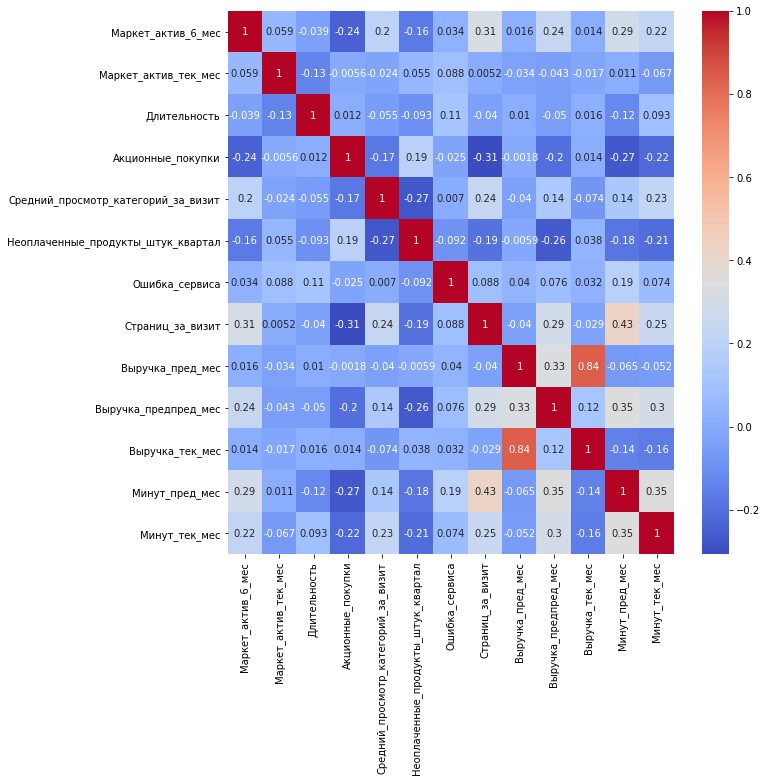

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

Вынесем коэффициенты средней величины в отдельную таблицу


In [59]:
#вынесем коэффициенты средней величины в отдельную таблицу
coef_corr = corr_matrix.stack().reset_index()
coef_corr.columns = ['Признак_1', 'Признак_2', 'Корреляция']

#удаляем строки где корреляция признака с самим собой
coef_corr = coef_corr[coef_corr['Признак_1'] != coef_corr['Признак_2']]

#фильтруем коэффициенты по условию
#coef_corr = coef_corr[(coef_corr['Корреляция'] < -0.2) or (coef_corr['Корреляция'] > 0.2)]
coef_corr = coef_corr[coef_corr['Корреляция'] > 0.2].drop_duplicates(subset='Корреляция')

In [60]:
coef_corr.sort_values(by='Корреляция', ascending=False)

,Признак_1,Признак_2,Корреляция
114,Выручка_пред_мес,Выручка_тек_мес,0.837813
102,Страниц_за_визит,Минут_пред_мес,0.425325
155,Минут_пред_мес,Минут_тек_мес,0.349399
128,Выручка_предпред_мес,Минут_пред_мес,0.347279
113,Выручка_пред_мес,Выручка_предпред_мес,0.328247
7,Маркет_актив_6_мес,Страниц_за_визит,0.314881
129,Выручка_предпред_мес,Минут_тек_мес,0.299687
100,Страниц_за_визит,Выручка_предпред_мес,0.292719
11,Маркет_актив_6_мес,Минут_пред_мес,0.288170
103,Страниц_за_визит,Минут_тек_мес,0.254452


Корреляция признаков о Выручке за предыдущий и текущий месяц очень высокая 0.84. Она была видна и на матрице с учетом категориальных признаков.

Чтобы избавиться от проблемы мультиколлинеарности при моделировании, избавимся от признака Выручка текущего месяца.

In [61]:
market_full = market_full.drop('Выручка_тек_мес', axis=1)

### Вывод по корреляционному анализу

Корреляционный анализ был проведен с помощью построения матриц корреляции по коэффициенту Пирсона. Сначала для всех признаков, потом только для количественных.

* Корреляция 0.75 Покупательская активность - Страниц за визит

* Покупательская активность также коррелирует с коэффициентом от 0.30 до 0.75 с признаками
   
* **Минуты пред мес (0.69)**
* **Минуты тек мес (0.58)**
* **Маркет актив 6 мес (0.55)**
* **Средний просмотр категорий за визит (0.54)**
* **Акционные покупки (0.51)**
* **Неоплаченные продукты штук квартал (0.50)**
* **Выручка предпред мес (0.50)**
* **Популярная категория (0.30)**

Была выявлена высокая связь между признаками `Выручка_пред_мес` и `Выручка_тек_мес` (0.84). 

Избавились от признака `Выручка_тек_мес`, чтобы избежать переобучения модели.

## Обучение моделей с пайплайном

In [62]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [63]:
market_full.columns

Index(['id', 'Покупательская_активность', 'Тип_сервиса', 'Разрешить_сообщать',
       'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
       'Акционные_покупки', 'Популярная_категория',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_пред_мес', 'Выручка_предпред_мес',
       'Минут_пред_мес', 'Минут_тек_мес'],
      dtype='object')

In [64]:
X_train, X_test, y_train, y_test = train_test_split(
    market_full.drop(['Покупательская_активность','id'], axis=1),
    market_full['Покупательская_активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = market_full['Покупательская_активность'])

In [65]:
X_train.shape, X_test.shape

((972, 15), (325, 15))

In [66]:
ohe_columns = ['Популярная_категория','Разрешить_сообщать']
ord_columns = ['Тип_сервиса']
num_columns = ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес',
               'Длительность', 'Акционные_покупки','Средний_просмотр_категорий_за_визит',
               'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит',
               'Выручка_пред_мес', 'Выручка_предпред_мес','Минут_пред_мес', 'Минут_тек_мес']

In [67]:
# создаём пайплайн для подготовки признаков из списка ohe_columns:
# заполнение пропусков и OHE-кодирование SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'ohe',
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
        )
    ]
)

In [68]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', OrdinalEncoder(), ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [69]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [70]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # словарь для модели SVC()
    {
        'models': [SVC(probability=True)],
        'models__kernel': ['linear', 'rbf']
    }
]

Метрика F1 — это среднее гармоническое между precision и recall, его значение лежит в диапазоне [0,1]. F1 достигает максимального значения, когда исходные метрики равны единице. Если хотя бы одна из исходных метрик близка к нулю, то и F1 тоже стремится к нулю. У нас нет необходимости найти оптимальный баланс модели, при котором она будет допускать приемлемое число ошибок обоих родов.

ROC-AUC — это всеохватывающая метрика качества классификации. Она учитывает работу модели при всех возможных значениях порогов и поэтому не зависит от одного конкретного. Кроме того, мы не занимались решением вопроса дисбаланса классов. А метрика ROC-AUC применяется когда необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности. Метрику можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими.

In [71]:
grid = GridSearchCV(
    pipe_final,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [72]:
#запускаем таймер
start = time.time()
 
grid.fit(X_train, y_train)

grid_search_time = time.time() - start
print(f'Search time: {grid_search_time}')


Search time: 14.64054250717163


In [73]:
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['Популярная_категория',
                                                   'Разрешить_сообщать']),
                                                 ('ord', OrdinalEncoder(),
                                                  ['Тип_сервиса']),
                                                 ('num', MinMaxScaler(),
                                                  ['Маркет_актив_6_мес',
                                                   'Маркет_актив_тек_мес',
                                    

In [74]:
y_test_pred = grid.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

Метрика ROC-AUC на тестовой выборке: 0.9207791686727651


Для перебора гиперпараметров мы выбрали GridSearchCV, пайплайн отработал достаточно быстро - за 8с. Так мы точно проверили все гиперпараметры и получили метрику на тестовой выборке 0.92.

### Промежуточный вывод

**Основные шаги:**

Предобработка данных:
Данные были подготовлены с использованием пайплайнов, которые включали кодирование категориальных переменных (OneHotEncoder), преобразование порядковых переменных (OrdinalEncoder) и масштабирование числовых признаков (MinMaxScaler). Это обеспечило адекватную подготовку признаков для обучения различных моделей.


**Выбор модели и настройка гиперпараметров:**

Использовались разные алгоритмы классификации (Decision Tree, K-Nearest Neighbors, Logistic Regression, и SVM) с последующим тонким подбором гиперпараметров через GridSearchCV. Это позволило идентифицировать настройки для каждой модели, а также сравнить их эффективность.

**Оценка модели:** Для оценки модели использовалась метрика ROC-AUC, в результате получили хорошую величину 0.92 на тестовой выборке.

**Лучшая модель:** SVC. Поиск занял около 13 секунд немного, особенно учитывая, что использовался метод GridSearchCV, обеспечивающий тщательный перебор всех комбинаций параметров.

## Анализ важности признаков

Далее нужно оценить вклад признаков модели по коэффициентам значимости модели.

### Оценка важности и график важности SHAP

Выведем на экран график важности признаков обученной модели. Отсортируем признаки по убыванию значимости.

Построим столбчатую диаграмму с помощью SHAP, покажем средний вклад каждого признака в результат работы модели. 

In [75]:
# Получим обученной модели из пайплайна
model = grid.best_estimator_.named_steps['models']
# Получим обработчик признаков из пайплайна
preprocessor = grid.best_estimator_.named_steps['preprocessor']

In [76]:
model

SVC(probability=True)

In [77]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False))]),
                                 ['Популярная_категория',
                                  'Разрешить_сообщать']),
                                ('ord', OrdinalEncoder(), ['Тип_сервиса']),
                                ('num', MinMaxScaler(),
                                 ['Маркет_актив_6_мес', 'Маркет_актив_тек_мес',
                                  'Длительность', 'Акционные_покупки',
                                  'Средний_просмотр_категорий_за_визит',
                                  'Неоплаченные_продукты_штук_квартал',
                                  'Ошибка_сервиса', 'Страниц_за_визит',
                                  'Выручка_пред_мес', 'Выручка_предпред_мес',
      

In [78]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [79]:
ohe_transformer = preprocessor.named_transformers_['ohe']['ohe']
ohe_feature_names = ohe_transformer.get_feature_names(input_features=ohe_columns)

In [80]:
ord_feature_names = ord_columns
num_feature_names = num_columns

In [81]:
feature_names = np.concatenate([ohe_feature_names, ord_feature_names, num_feature_names])

In [82]:
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed, columns=feature_names)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

In [83]:
feature_names

array(['Популярная_категория_Косметика и аксесуары',
       'Популярная_категория_Кухонная посуда',
       'Популярная_категория_Мелкая бытовая техника и электроника',
       'Популярная_категория_Техника для красоты и здоровья',
       'Популярная_категория_Товары для детей', 'Разрешить_сообщать_нет',
       'Тип_сервиса', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес',
       'Длительность', 'Акционные_покупки',
       'Средний_просмотр_категорий_за_визит',
       'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
       'Страниц_за_визит', 'Выручка_пред_мес', 'Выручка_предпред_мес',
       'Минут_пред_мес', 'Минут_тек_мес'], dtype=object)

In [84]:
COUNT = 30

In [85]:
# Семпл данных для KernelExplainer
X_train_preprocessed_smpl = shap.sample(X_train_preprocessed_df, COUNT, random_state=RANDOM_STATE)
X_test_preprocessed_smpl = shap.sample(X_test_preprocessed_df, COUNT, random_state=RANDOM_STATE)

  0%|          | 0/30 [00:00<?, ?it/s]

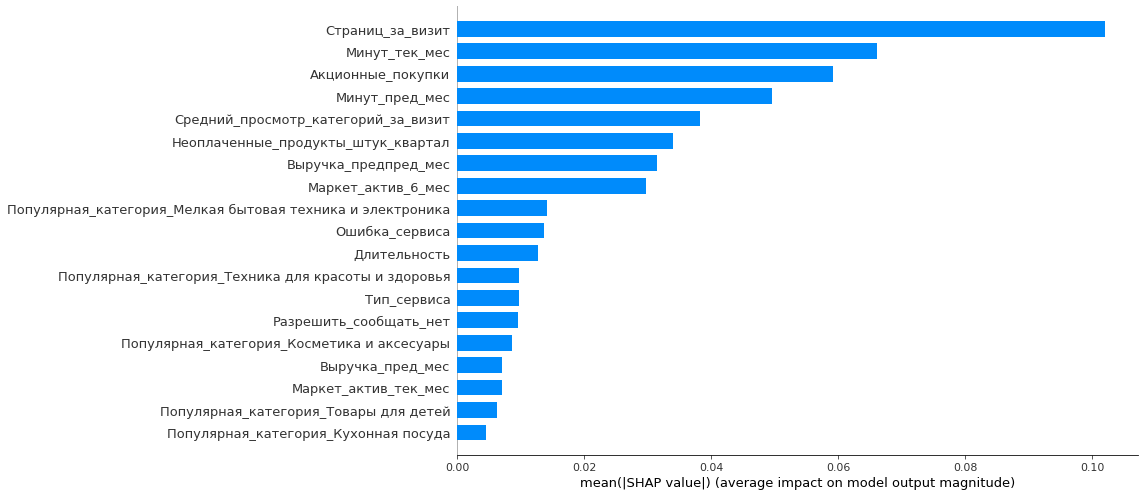

In [86]:
# Теперь, когда у нас есть DataFrame с именами признаков, мы можем использовать KernelExplainer
explainer = shap.KernelExplainer(model.predict_proba, X_train_preprocessed_smpl)
shap_values = explainer.shap_values(X_test_preprocessed_smpl)

# Построение графика с именами признаков
shap.summary_plot(shap_values[:,:,1], X_test_preprocessed_smpl, plot_type='bar',plot_size=(16,7))

### Промежуточный вывод

1. Из пайплайна извлекли обученную лучшую модель SVC и обработчик признаков. Данные обучающей и тестовой выборок были преобразованы, получены имена признаков.

 Создан KernelExplainer с помощью библиотеки SHAP для объяснения предсказаний модели. Вычислены значения SHAP для семплов обучающей и тестовой выборок, построен график важности признаков с использованием shap.summary_plot.

2. **Наиболее важные признаки:**  
 * `Страниц_за_визит`
 * `Минут_тек_мес`
 * `Акционные_покупки`
 * `Минут_пред_мес`
 * `Маркет_актив_6_мес`
 * `Средний_просмотр_категорий_за_визит`
 * `Неоплаченные_продукты_штук_квартал`
 * `Выручка_предпред_мес`
 * `Ошибка_сервиса`
 
 демонстрируют наибольшую важность среди всех. Эти признаки имеют высокие значения важности, что говорит о их сильном влиянии на предсказания модели.

 **Признаки средней и малой важности**
 * `Длительность`
 * `Тип_сервиса`
 * `Маркет_актив_тек_мес`
 * `Выручка_пред_мес`
 * `Популярные категории`

 имеют низкую важность. Изменения в этих признаках почти не влияют на результаты модели.

## Сегментация покупателей

### 8.1 Сегментация

Воспользуемся результатом моделирования, чтобы сегментировать покупателей по выручке и целевому признаку Покупательская активность.

In [101]:
#X = market_full
X = market_full.drop(['id','Покупательская_активность'], axis=1)

In [103]:
#Получим предсказания модели
best_model = grid.best_estimator_
predictions = best_model.predict_proba(X)[:, 1]
predictions

array([0.95926411, 0.53893976, 0.90944425, ..., 0.06280984, 0.11181985,
       0.31564934])

Воспользуемся графиком shap, используем самые влиятельные 9 признаков.

Построим диаграммы рассеяния scatterplot, основываясь на данных моделирования predictions, которые будут осью Y диаграмм. Посмотрим на распределение покупателей относительно признаков, чтобы отобрать покупателей и сегментировать.

In [122]:
X['Покупательская_активность'] = market_full['Покупательская_активность']
X['id'] = market_full['id']

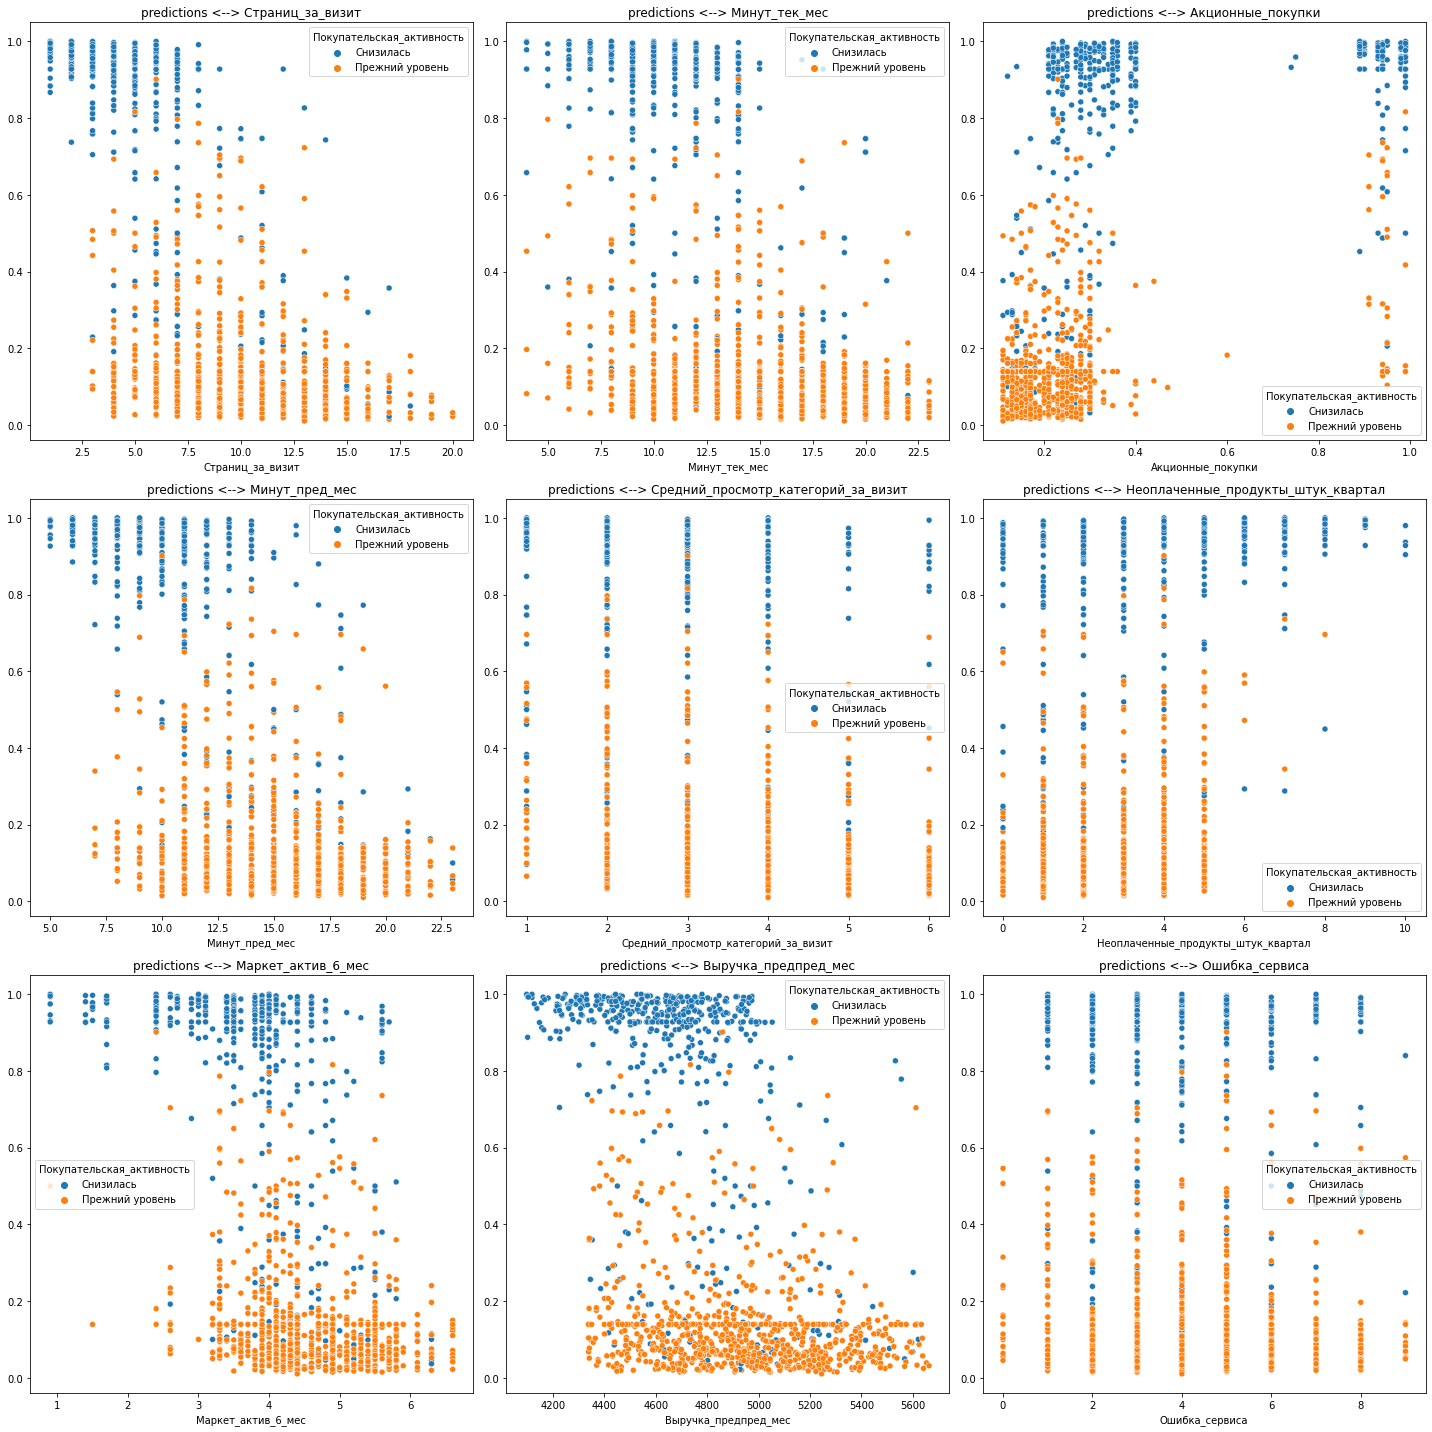

In [123]:
# Создадим список признаков
quantitative_scatter = ['Страниц_за_визит', 'Минут_тек_мес', 'Акционные_покупки', 
                        'Минут_пред_мес', 'Средний_просмотр_категорий_за_визит',
                        'Неоплаченные_продукты_штук_квартал', 'Маркет_актив_6_мес',
                        'Выручка_предпред_мес', 'Ошибка_сервиса']

# Построение диаграмм рассеяния
plt.figure(figsize=(20, 20))

for i, feature in enumerate(quantitative_scatter, 1):
    plt.subplot(3, 3, i)
    sns.scatterplot(data=X, 
                    x=feature, 
                    y=predictions,
                    hue='Покупательская_активность')
    plt.title(f'predictions <--> {feature}')

plt.tight_layout()
plt.show()

На графике выберем примерную границу разделения классов 0 и 1 (или значение Покупательской-активности - Снизилась\Прежний уровень). Плавный переход происходит на промежутке 0.2 - 0.8, выберем 0.6 - значение вероятности отнесения к классу 1 - Снизилась покупательская активность.

Вынесем покупателей с predictions выше 0.6 и посмотрим на них в разных категориях.

In [124]:
X['pred_proba'] = predictions
market_decrease_predicted = X[X['pred_proba'] >= 0.6]

#### Выручка предпредыдущего месяца


In [125]:
market_decrease_predicted.head(5)

,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_пред_мес,Выручка_предпред_мес,Минут_пред_мес,Минут_тек_мес,Покупательская_активность,pred_proba,id
0,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,12,10,Снизилась,0.959264,215349
2,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,11,13,Снизилась,0.909444,215351
3,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,8,11,Снизилась,0.952443,215352
4,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,10,10,Снизилась,0.834171,215353
5,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,11,12,Снизилась,0.737185,215354


Создадим 3 сегмента группы по средней выручке и посмотрим на них в разрезе Покупательской активности.

In [126]:
# Функция для классификации выручки
def classify_revenue(revenue):
    if revenue <= 4503.0:
        return 'Низкая'
    elif revenue <= 4723.0:
        return 'Средняя'
    else:
        return 'Высокая'

In [127]:
# Применение классификации к выручке
market_decrease_predicted['Класс_выручки'] = market_decrease_predicted['Выручка_предпред_мес'].apply(classify_revenue)
market_decrease_predicted.head(5)

/tmp/ipykernel_63/4237537942.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_decrease_predicted['Класс_выручки'] = market_decrease_predicted['Выручка_предпред_мес'].apply(classify_revenue)


,Тип_сервиса,Разрешить_сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_пред_мес,Выручка_предпред_мес,Минут_пред_мес,Минут_тек_мес,Покупательская_активность,pred_proba,id,Класс_выручки
0,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,12,10,Снизилась,0.959264,215349,Низкая
2,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,11,13,Снизилась,0.909444,215351,Высокая
3,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,8,11,Снизилась,0.952443,215352,Средняя
4,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,10,10,Снизилась,0.834171,215353,Высокая
5,стандарт,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2,5685.0,4503.0,11,12,Снизилась,0.737185,215354,Низкая


In [128]:
# Вычисление средней выручки для каждой группы
average_revenue_per_group = market_decrease_predicted.groupby('Класс_выручки')['Выручка_предпред_мес'].mean()

# Добавление средней выручки к каждой строке
market_decrease_predicted['Средняя_выручка'] = market_decrease_predicted['Класс_выручки'].map(average_revenue_per_group)

/tmp/ipykernel_63/2379742396.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_decrease_predicted['Средняя_выручка'] = market_decrease_predicted['Класс_выручки'].map(average_revenue_per_group)


In [129]:
market_decrease_predicted[['Покупательская_активность', 'Выручка_предпред_мес', 'Класс_выручки', 'Средняя_выручка']].head()

,Покупательская_активность,Выручка_предпред_мес,Класс_выручки,Средняя_выручка
0,Снизилась,4472.0,Низкая,4344.798507
2,Снизилась,4793.0,Высокая,4887.514706
3,Снизилась,4594.0,Средняя,4616.742424
4,Снизилась,5124.0,Высокая,4887.514706
5,Снизилась,4503.0,Низкая,4344.798507


### 8.2 Выбор группы

#### Выручка

Построим графики соотношений групп.


In [130]:
average_revenue_per_group

Класс_выручки
Высокая    4887.514706
Низкая     4344.798507
Средняя    4616.742424
Name: Выручка_предпред_мес, dtype: float64

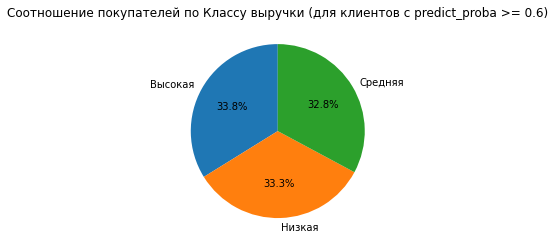

In [132]:
market_revenue_decreased = market_decrease_predicted.pivot_table(
    index='Класс_выручки',
    values='id',
    aggfunc='count')

plt.pie(market_revenue_decreased['id'], 
        labels = market_revenue_decreased.index, 
        autopct = '%1.1f%%', 
        startangle = 90)
plt.title('Соотношение покупателей по Классу выручки (для клиентов с predict_proba >= 0.6)')
plt.show()

Группы оказались равными по количеству покупателей.

Сейчас мы не делаем анализ, а ищем группу покупателей, с которой нужно работать. Здесь у нас есть несколько вариантов:
* Обратить внимание на группу Низкой выручки, чтобы усилиями МА в дальнейшем эти клиенты стали группой с Высокой выручкой (с увеличением ПА естественно)
* Работать с клиентами из группы Высокая выручка, так как их лояльность выручкой уже была подтверждена и, возможно, потребует меньше усилий для их возврата к нашему магазину.

#### Страниц за визит

In [133]:
market_decrease_predicted_pages = market_decrease_predicted.pivot_table(
    index='Страниц_за_визит',
    values='id',
    aggfunc='count')

market_decrease_predicted_pages

,id
Страниц_за_визит,
1,20
2,57
3,67
4,76
5,74
6,52
7,26
8,9
9,8


Клиенты с `[predict_proba] >= 0.6` просмотревшие менее 8 страниц исчисляются десятками. При увеличении количества страниц их количество падает. Возможно, до просмотра 7 страниц клиенты оказываются не готовы к покупкам и соскакивают. 

Здесь мы не анализируем причины, а выбираем эту группу `['Страниц_за_визит'] <= 7` для работы с ними. К тому же она достаточно многочисленная.

#### Акционные покупки

In [134]:
# Рассчитаем среднее значение для столбца 'Акционные_покупки'
discount_mean = market_decrease_predicted['Акционные_покупки'].mean()

In [135]:
# Добавим новый столбец для группировки
market_decrease_predicted['Группа_акционных_покупок'] = market_decrease_predicted['Акционные_покупки'].apply(
    lambda x: 'Много' if x >= discount_mean else 'Мало'
)

/tmp/ipykernel_63/3056478226.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  market_decrease_predicted['Группа_акционных_покупок'] = market_decrease_predicted['Акционные_покупки'].apply(


In [136]:
market_decrease_predicted_discount = market_decrease_predicted.pivot_table(
    index='Группа_акционных_покупок',
    values=['id', 'Средняя_выручка'],
    aggfunc={'id': 'count', 'Средняя_выручка': 'mean'}
)


market_decrease_predicted_discount

,id,Средняя_выручка
Группа_акционных_покупок,,
Мало,266,4609.211611
Много,136,4634.299350


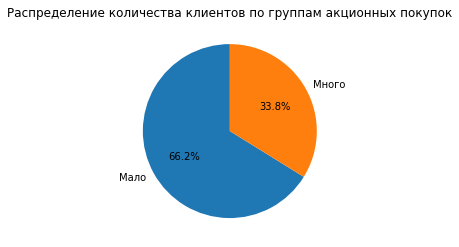

In [137]:
plt.figure()
plt.pie(market_decrease_predicted_discount['id'], 
        labels=market_decrease_predicted_discount.index, 
        autopct='%1.1f%%', 
        startangle=90)
plt.title('Распределение количества клиентов по группам акционных покупок')
plt.show()

2/3 клиентов попадает в категорию "Мало акционных покупок". Акции привлекают меньшую часть клиентской базы, при этом средняя выручка группы Мало примерно такая же и даже немного больше.

Возможно, стоит рассмотреть группу Мало акционных покупок, чтобы исследовать вопрос: что мешает им совершать покупки по акции?

### Вывод по сегментации

Для проведения сегментации были использованы результаты модели и занесены в `predictions`. 

Построены диаграммы рассеяния для различных признаков против предсказаний, чтобы визуализировать распределение покупателей.
С их помощью выделили покупателей с высоким риском снижения активности `с pred_proba >= 0.6` для дальнейшего анализа.

* **Сегментация по выручке:**

 Определены границы квантилей для сегментации по выручке и созданы группы поэтим границам: 

 * Низкая выручка: клиенты с выручкой ниже 4503.0.
 * Средняя: от 4503.0 до 4723.0.
 * Высокая: выше 4723.0.

* **Просмотрено страниц:**
 
 Чем меньше просмотрено страниц, тем больше клиентов класса Снижена ПА. Выбрано число страниц = 7 и ниже. По этому диапазону стоит выделить клиентов для работы с ними и увеличения их покупательской активности.

* **Группы по акционным покупкам:**
 
 Использовано среднее из столбца Акционные покупки для определения группы:

 * Мало акционных покупок: доля акционных покупок ниже среднего значения.
 * Много акционных покупок: выше среднего значения.

 Примерно 2/3 клиентов попадает в категорию Мало. Средняя выручка группы Мало практически такая же, как и группы Много акционных покупок. Рекомендуем группу Мало акционных покупок для работы с ними и увеличения числа покупок по Акции.


## Общий вывод

**Описание задачи:**

Целью данного проекта было разработать предиктивную модель для классификации покупательской активности клиентов интернет-магазина на основе различных признаков, связанных с их предыдущими покупками, поведением на сайте, предпочтениями в категориях товаров и другими аспектами. Основная задача модели заключалась в определении типа покупательской активности (Снизится или Останется на прежнем уровне).


---


Для работы были предоставлены 4 датасета, которые были предобработаны и предварительно исследованы на поиск особенных значений и корреляций. Этот анализ показал

* Покупательская активность снижена у ~500 человек. Примерно 800 клиентов сохраняют прежнюю активность.

* Более 950 человек против 350 предпочитают получать дополнительные предложения о товаре.

* Самая популярная категория товаров - Товары для детей.

* Есть предположение, что низкое число маркетинговых активностей (ниже 5) влияет на сниженную покупательскую активность
* У распределения Акционных покупок 2 пика: близ 0.25 и 0.95. Скорее всег второй пик означает, что есть покупатели, совершающие только покупки по акции.

* Увеличилась дисперсия для распределения выручки от наиболее далекого периода Препредыдущий месяц до Текущий месяц. Также в Текущем месяце нет клиентов с Выручкой = 0. Максимальная выручка с клиента в Текущем месяце тоже увеличилась.

* Увеличилось время пребывания на сайте, что хорошо.

* Не обнаружено мультиколлинеарности.

* Самая высокая корреляция 0.75 Покупательская активность - Страниц за визит

* Есть множество признаков коррелирующих между собой со средним коэффициентом от 0.35 до 0.75, что дает хороший задел для обучения модели.



---


Для обучения модели данные были собраны в датасет market_full. Он содержал следующие колонки:

* Категориальные признаки, такие как тип сервиса и возможность отправлять сообщения.
* Количественные признаки, включая активность на маркете за последние 6 месяцев, длительность использования сервиса, количество акционных покупок и другие.

Предобработка данных включала следующие шаги:

* Кодирование категориальных переменных через OneHotEncoder, что позволило преобразовать номинативные признаки в числовой формат.
* Преобразование порядковых переменных с помощью OrdinalEncoder.
* Масштабирование количественных признаков с использованием MinMaxScaler для унификации масштабов и улучшения процесса обучения моделей.

**Поиск лучшей модели:**

Использовались различные модели классификации, включая Decision Tree, K-Nearest Neighbors (KNN), Logistic Regression, и Support Vector Machines (SVM).
Применялся метод GridSearchCV для настройки гиперпараметров и выбора лучшей модели на основе метрики ROC-AUC, потому что она оптимальна для несбалансированных классов.

**Лучшая модель:** SVC. Поиск занял около 13 секунд немного, особенно учитывая, что использовался метод GridSearchCV, обеспечивающий тщательный перебор всех комбинаций параметров. 

ROC-AUC в результате равна 0.92.

**Выводы по сегментации покупателей:**

Для сегментации были использованы результаты моделирования для получения вероятностей предсказаний и построение shap для выбора признаков, на которых основывали сегментацию.
Построены диаграммы рассеяния для различных признаков против предсказаний, чтобы визуализировать распределение покупателей.
С их помощью выделили покупателей с высоким риском снижения активности `с pred_proba >= 0.6` для дальнейшего анализа.

* **Сегментация по выручке:**
 Определены границы квантилей для сегментации по выручке и созданы группы поэтим границам: 
 * Низкая выручка: клиенты с выручкой ниже 4503.0.
 * Средняя: от 4503.0 до 4723.0.
 * Высокая: выше 4723.0.

* **Просмотрено страниц:**
 Чем меньше просмотрено страниц, тем больше клиентов класса Снижена ПА. Выбрано число страниц = 7 и ниже. По этому диапазону стоит выделить клиентов для работы с ними и увеличения их покупательской активности.

* **Группы по акционным покупкам:**
 * Мало акционных покупок: доля акционных покупок ниже среднего значения.
 * Много акционных покупок: выше среднего значения.

 Примерно 2/3 клиентов попадает в категорию Мало. Средняя выручка группы Мало практически такая же, как и группы Много акционных покупок. Рекомендуем группу Мало акционных покупок для работы с ними и увеличения числа покупок по Акции.

Все три рассмотрения предполагают выделения группы наиболее "проседающих" клиентов, id которых можно отправить для обработки маркетингу.

Саму модель можно использовать для предсказания дальнейшей Покупательской активности, чтобы упреждать снижение выручки.